# Exercise 03: CLIP zero-shot prediction
In this exercise, you will perform zero-shot prediction using CLIP.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST  # 修改此行
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 100
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP
VISUAL_BACKBONE = 'RN50' # RN50, ViT-B/32, ViT-B/16


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
transform_mnist_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),  # 转换为RGB格式
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4, 0.4, 0.4), (0.4, 0.4, 0.4)),  # 根据MNIST的均值和标准差进行归一化
])

test_set = torchvision.datasets.MNIST(root='/data/dataset/', train=False,
                                       download=True, transform=transform_mnist_test)  # 修改此行

# 修改类别名称
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
dataset_name = 'MNIST'



### Model

In [5]:
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/data/home/wsy/.cache/clip/')
model.to(device)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

### Encode text 

In [6]:
prompt = "asdqwedqwdwda"

text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)


### Task 1: Zero-shot accuracy calculation
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [7]:

def model_inference(model, image):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()

    ###############################################################

    return logits

### Zero-shot Inference

In [8]:
testing_loss = []
testing_acc = []

# 添加以下代码以定义MNIST测试数据加载器
test_dataloader_mnist = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# 在模型评估部分使用test_dataloader_mnist
with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader_mnist):  # 修改此行

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on MNIST is 37.43%, visual encoder is RN50.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


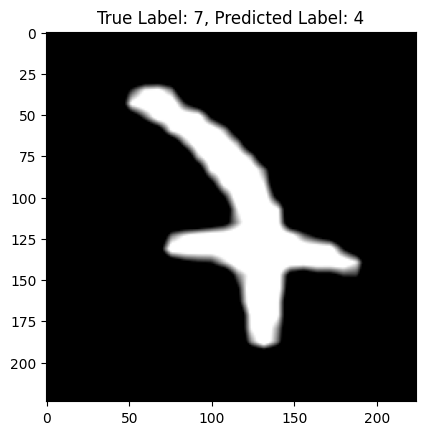

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


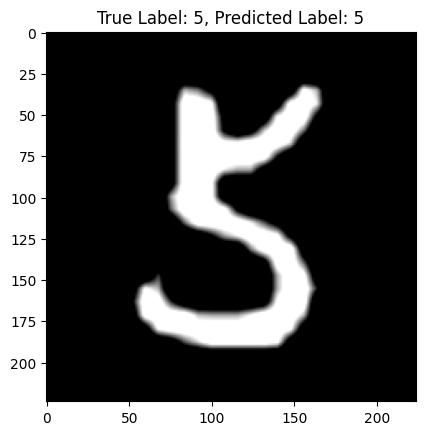

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


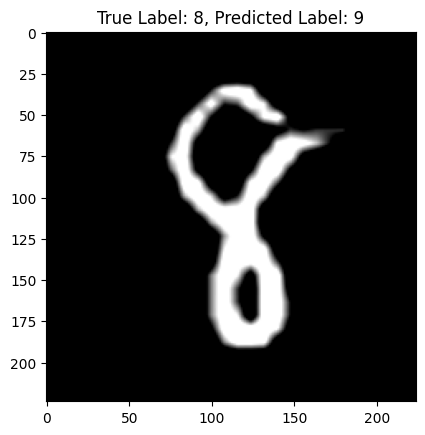

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


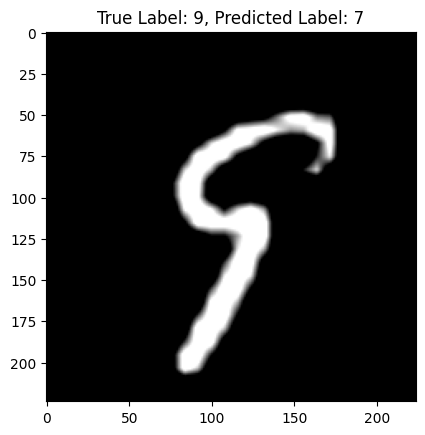

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


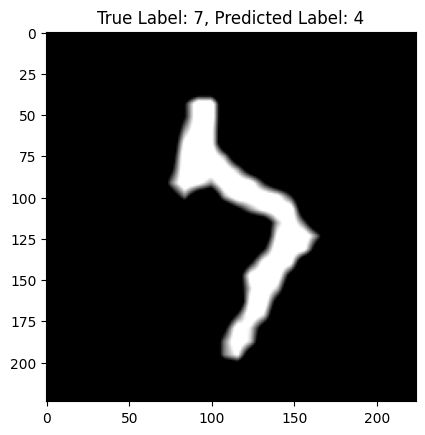

RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/opt/pytorch/pytorch/c10/cuda/CUDACachingAllocator.cpp":1150, please report a bug to PyTorch. 

In [9]:
import random
import numpy as np

model.eval()

num_visualizations = 10  # 要可视化的示例数量

for _ in range(num_visualizations):
    idx = random.randint(0, len(test_set)-1)
    image, target = test_set[idx]

    # 不要进行转换，直接使用原始的PIL图像
    image_tensor = image.unsqueeze(0).to(device)

    logits = model_inference(model, image_tensor)
    _, pred = torch.max(logits, 1)

    # 调整图像形状以适应imshow的要求
    image_np = np.transpose(image.numpy(), (1, 2, 0))

    plt.imshow(image_np)
    plt.title(f"True Label: {class_names[target]}, Predicted Label: {class_names[pred.item()]}")
    plt.show()